## Training CycleGAN

In [10]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from data_loading import ImageDataset
from utils import Parameters
from cyclegan import CycleGAN
import skimage.io as io
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Specify Hyperparameters

In [11]:
params = Parameters()
params.data_root = "./data"
params.dataset_name = "thermal" #dataset 
params.print_every = 5 #Log frequency
params.device = "cuda" if torch.cuda.is_available() else "cpu" #Device

params.epoch = 0 #Epoch to start training from 
params.n_epochs = 10 #number of epochs of training
params.learning_rate = 0.0001 #Learning rate for optimizers
params.beta1 = 0.5  #beta1 for Adam optimizer
params.beta2 = 0.999 #beta2 for Adam optimizer
params.decay_epoch = 1  #epoch to start lr decay
params.batch_size = 4 #size of the batches

params.img_height = 384 #height of the input image
params.img_width = 384 #width of the input image
params.channels = 1 #number of channels of the input image
params.n_residual_blocks = 2  #number of residual blocks in the models
params.lambda_cycle = 10.0 #cycle loss weight
params.lambda_identity = 5.0 #identity loss weight

## Preprocessing Data, and creating dataloaders

In [12]:

# Image transformations
transformations = [
    transforms.Resize((params.img_height, params.img_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
]

root_path = os.path.join(params.data_root, params.dataset_name)
# Training data loader
train_dataloader = DataLoader(
    ImageDataset(root_path, transforms_=transformations, unaligned=True, mode = "train"),
    batch_size= params.batch_size,
    shuffle=True,
)

# Test data loader
val_dataloader = DataLoader(
    ImageDataset(root_path, transforms_=transformations, unaligned=True, mode="test"),
    batch_size= params.batch_size,
    shuffle=True,
)

 ## Creating Instance of CycleGAN

In [13]:
cyclegan = CycleGAN(params)

2022-08-01 09:18:14.304552: INFO: cyclegan: __init__: Traininable Parameters in Generator (G_AB): 3,101,441
2022-08-01 09:18:14.310536: INFO: cyclegan: __init__: Traininable Parameters in Generator (G_BA): 3,101,441
2022-08-01 09:18:14.315525: INFO: cyclegan: __init__: Traininable Parameters in Discriminator (D_A): 2,762,689
2022-08-01 09:18:14.321507: INFO: cyclegan: __init__: Traininable Parameters in Discriminator (D_B): 2,762,689


### Training the CycleGAN model. 

In [ ]:
cyclegan.train(train_dataloader, val_dataloader)

### Loading pretrained models from checkpoint paths

In [14]:
generator_ab_path = "./checkpoints/thermal/G_AB_9.pth"
generator_ba_path = "./checkpoints/thermal/G_BA_9.pth"
discriminator_a_path = "./checkpoints/thermal/D_A_9.pth"
discriminator_b_path = "./checkpoints/thermal/D_B_9.pth"

cyclegan.load_model("g_ab", generator_ab_path)
cyclegan.load_model("g_ba", generator_ba_path)
cyclegan.load_model("d_a", discriminator_a_path)
cyclegan.load_model("d_b", discriminator_b_path)

## Load Original Image for Translation

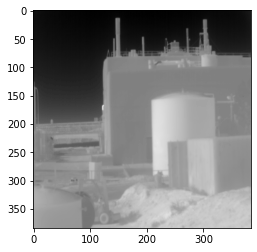

In [27]:
image = io.imread("data/thermal/train/A/20220218_193327_660.png", as_gray =True)
image = resize(image, (384, 384))
plt.imshow(image, cmap='gray')

## Domain A to B translation

In [28]:
image_tensor = torch.Tensor(image)
image_tensor = torch.unsqueeze(image_tensor, 0)
image_tensor = torch.unsqueeze(image_tensor, 0)
print(image_tensor.shape)

torch.Size([1, 1, 384, 384])


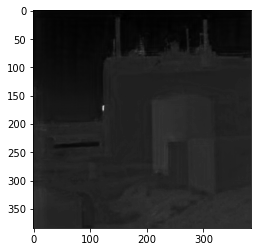

In [29]:
translated_image_ab = cyclegan.translate_image(image_tensor, "a", "b")
numpy_translated_image =  translated_image_ab.detach().numpy()
plt.imshow(numpy_translated_image[0][0], cmap='gray')

## Domain B to A translation

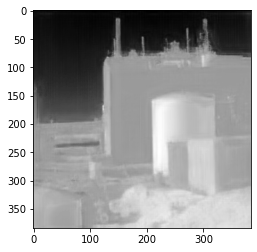

In [30]:
translated_image_ba = cyclegan.translate_image(image_tensor, "b", "a")
numpy_translated_image =  translated_image_ba.detach().numpy()
plt.imshow(numpy_translated_image[0][0], cmap='gray')